In [ ]:
import os, json, math, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/SIH/data"

buffalo  cattle  class_names.json


In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/SIH/data/cattle"

In [ ]:
if os.path.isdir(DATA_DIR):
  print(f"Folder found: {DATA_DIR}")
else:
  print(f"Folder not found: {DATA_DIR}")

Folder found: /content/drive/MyDrive/Colab Notebooks/SIH/data/cattle


In [ ]:
def explore_dataset(data_dir):
    """
    Explore the dataset structure and show sample counts
    """
    print("Dataset Structure:")
    print("-" * 40)

    breeds = []
    image_counts = []

    if os.path.exists(data_dir):
        for breed_folder in sorted(os.listdir(data_dir)):
            breed_path = os.path.join(data_dir, breed_folder)
            if os.path.isdir(breed_path):
                image_count = len([f for f in os.listdir(breed_path)
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                breeds.append(breed_folder)
                image_counts.append(image_count)
                print(f"{breed_folder}: {image_count} images")

    total_images = sum(image_counts)
    print("-" * 40)
    print(f"Total Images: {total_images}")
    print(f"Total Breeds: {len(breeds)}")

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(breeds, image_counts, color=['skyblue' if 'cattle' in breed.lower() else 'lightcoral' for breed in breeds])
    plt.title('Distribution of Images per Breed')
    plt.xlabel('Breed')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return breeds, image_counts

Dataset Structure:
----------------------------------------
Ayrshire cattle: 260 images
Brown Swiss cattle: 238 images
Holstein Friesian cattle: 254 images
Jersey cattle: 252 images
Red Dane cattle: 204 images
----------------------------------------
Total Images: 1208
Total Breeds: 5


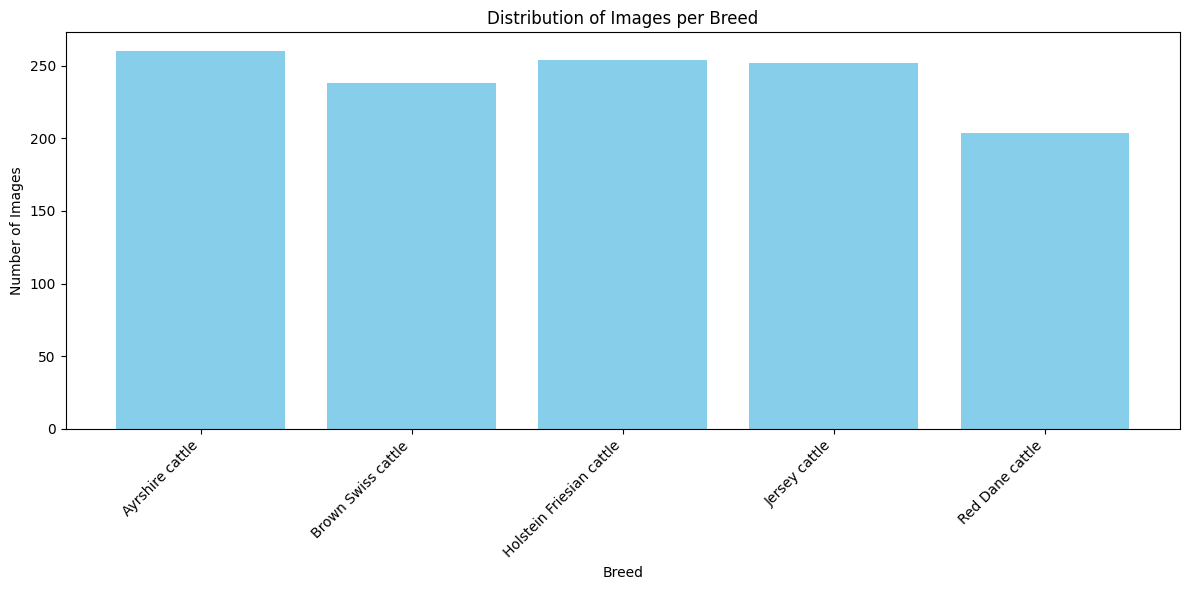

In [ ]:
# Explore your dataset
breeds, counts = explore_dataset(DATA_DIR)

In [ ]:
import os
for cls in sorted(os.listdir(DATA_DIR)):
    cls_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(cls_path):
        print(cls, len(os.listdir(cls_path)))


Ayrshire cattle 260
Brown Swiss cattle 238
Holstein Friesian cattle 254
Jersey cattle 252
Red Dane cattle 204


In [ ]:
IMG_SIZE = 224  # ResNet50 default
BATCH_SIZE = 32
VAL_SPLIT = 0.20       # 20% for val+test (we'll split this in half later into val and test)
SEED = 42
COLOR_MODE = "rgb"
LEARNING_RATE = 0.0001

In [ ]:
# Load datasets (train / val_temp)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",       # Automatically label based on folder
    label_mode="int",        # keep integer labels; we can one-hot later inside the model
    class_names=None,        # infer from subfolder names
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),     # will resize for you
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training",
)


Found 1208 files belonging to 5 classes.
Using 967 files for training.


In [ ]:
val_temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation",
)

Found 1208 files belonging to 5 classes.
Using 241 files for validation.


In [ ]:
# Save class names (folder names) for later use
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Ayrshire cattle', 'Brown Swiss cattle', 'Holstein Friesian cattle', 'Jersey cattle', 'Red Dane cattle']


In [ ]:
# Check the labels
#print("Class labels:", train_ds.class_indices)
label_map = {i: name for i, name in enumerate(class_names)}
print(label_map)

{0: 'Ayrshire cattle', 1: 'Brown Swiss cattle', 2: 'Holstein Friesian cattle', 3: 'Jersey cattle', 4: 'Red Dane cattle'}


In [ ]:
''' so, mapping will be
'Ayrshire cattle' → 0
'Brown Swiss cattle' → 1
'Guernsey cattle' → 2
'Holstein cattle' → 3
'Jersey cattle' → 4
'''

" so, mapping will be\n'Ayrshire cattle' → 0\n'Brown Swiss cattle' → 1\n'Guernsey cattle' → 2\n'Holstein cattle' → 3\n'Jersey cattle' → 4\n"

In [ ]:
# Save mapping to file
label_map = {i: name for i, name in enumerate(class_names)}
#print(label_map)
with open("/content/drive/MyDrive/Colab Notebooks/SIH/data/class_names.json", "w") as f:
    json.dump(label_map, f, indent=2)
print("/content/drive/MyDrive/Colab Notebooks/SIH/data/class_names.json")

/content/drive/MyDrive/Colab Notebooks/SIH/data/class_names.json


In [ ]:
for images, labels in train_ds.take(1): # take first batch
  print("Labels: ",labels.numpy())
  print("Class names: ", [class_names[i] for i in labels.numpy()])

Labels:  [0 1 1 2 4 3 0 2 2 3 4 4 3 0 0 2 2 4 0 0 3 0 4 2 3 0 4 1 3 4 0 1]
Class names:  ['Ayrshire cattle', 'Brown Swiss cattle', 'Brown Swiss cattle', 'Holstein Friesian cattle', 'Red Dane cattle', 'Jersey cattle', 'Ayrshire cattle', 'Holstein Friesian cattle', 'Holstein Friesian cattle', 'Jersey cattle', 'Red Dane cattle', 'Red Dane cattle', 'Jersey cattle', 'Ayrshire cattle', 'Ayrshire cattle', 'Holstein Friesian cattle', 'Holstein Friesian cattle', 'Red Dane cattle', 'Ayrshire cattle', 'Ayrshire cattle', 'Jersey cattle', 'Ayrshire cattle', 'Red Dane cattle', 'Holstein Friesian cattle', 'Jersey cattle', 'Ayrshire cattle', 'Red Dane cattle', 'Brown Swiss cattle', 'Jersey cattle', 'Red Dane cattle', 'Ayrshire cattle', 'Brown Swiss cattle']


In [ ]:
# revesre mapping
class_to_idx = {name: i for i, name in enumerate(class_names)}
print(class_to_idx)


{'Ayrshire cattle': 0, 'Brown Swiss cattle': 1, 'Holstein Friesian cattle': 2, 'Jersey cattle': 3, 'Red Dane cattle': 4}


In [ ]:
# Split val_temp into real val and test (50/50)

In [ ]:
# In TensorFlow, a tf.data.Dataset doesn’t store everything in memory — it’s a pipeline of operations (like “read images → resize → batch → shuffle”)
# To know how many batches are inside the dataset, you use: tf.data.experimental.cardinality(dataset)
# This returns a special TensorFlow object (tf.Tensor) representing the count of batches
val_temp_batches = tf.data.experimental.cardinality(val_temp_ds).numpy()
print(val_temp_batches)

8


In [ ]:
test_ds = val_temp_ds.take(val_temp_batches // 2)
val_ds  = val_temp_ds.skip(val_temp_batches // 2)

In [ ]:
print("Batches -> train:", tf.data.experimental.cardinality(train_ds).numpy(),
      "| val:", tf.data.experimental.cardinality(val_ds).numpy(),
      "| test:", tf.data.experimental.cardinality(test_ds).numpy())

Batches -> train: 31 | val: 4 | test: 4


In [ ]:
print(32*(31+4+4))
print(260+238+254+252+204) # last batch are not full

1248
1208


Data augmentation (training only)

In [ ]:
#    Keep augmentations conservative to avoid distorting breed characteristics.
#    NOTE: These layers work fine before preprocess_input(i.e., before preprocess_input). Augmentation works on normal images (0–255 pixel range)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.15),  # Increased from 0.05 to 0.15 (~±27°)
    tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15),  # Increased from 0.05 to 0.15
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Increased from 0.05 to 0.1
    tf.keras.layers.RandomBrightness(0.2),  # brightness variation
    tf.keras.layers.RandomContrast(0.2),    # contrast variation
], name="data_augmentation")

Preprocess for ResNet50

In [ ]:
#    Use tf.keras.applications.resnet50.preprocess_input (Caffe-style: BGR, mean subtraction).
#    Do NOT also rescale 1/255.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def add_augmentation(image, label):
    # Apply only on training
    image = data_augmentation(image, training=True)
    return image, label

In [ ]:
def preprocess_for_resnet(image, label):
    image = tf.cast(image, tf.float32)      # convert to float32
    image = preprocess_input(image)  # expects float32 in [0..255]
    return image, label

In [ ]:
# Apply augmentation to train only, then preprocess on all sets
train_ds = (train_ds
            .map(add_augmentation, num_parallel_calls=AUTOTUNE)
            .map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE))

In [ ]:
val_ds   = val_ds.map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE)

pipeline optimizations:- Caching, shuffling, prefetching (performance)
Cache to disk to avoid RAM spikes on large datasets in Colab.

In [ ]:
train_ds = (train_ds
            .cache("/tmp/cattle_train.cache")
            .shuffle(buffer_size= BATCH_SIZE * 8, seed=SEED, reshuffle_each_iteration=True)
            .prefetch(AUTOTUNE))

val_ds   = val_ds.cache("/tmp/cattle_val.cache").prefetch(AUTOTUNE)
test_ds  = test_ds.cache("/tmp/cattle_test.cache").prefetch(AUTOTUNE)

Quick sanity checks

In [ ]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape, "Label batch shape:", labels.shape)
    print("Label dtype:", labels.dtype)
    print("Min/Max pixel after preprocess_input:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())

'for images, labels in train_ds.take(1):\n    print("Image batch shape:", images.shape, "Label batch shape:", labels.shape)\n    print("Label dtype:", labels.dtype)\n    print("Min/Max pixel after preprocess_input:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())'

Class distribution — helpful later for class weight

In [ ]:
import numpy as np

# Count labels in training dataset
train_class_counts = np.zeros(len(class_names))
for images, labels in train_ds.unbatch():
    train_class_counts[labels.numpy()] += 1

print("Class counts:", train_class_counts)


Class counts: [210. 195. 203. 203. 156.]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Collect all labels into a single 1D numpy array
y_labels = np.array([labels.numpy() for _, labels in train_ds.unbatch()])
#print(y_labels)


class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(class_names)),
    y=y_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.920952380952381), 1: np.float64(0.9917948717948718), 2: np.float64(0.9527093596059113), 3: np.float64(0.9527093596059113), 4: np.float64(1.2397435897435898)}


In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [ ]:
num_classes = len(class_names)

In [ ]:

# Load base ResNet50 (pretrained on ImageNet)
'''base_model = tf.keras.applications.ResNet50(
    include_top=False,  # remove old classifier head
    weights="imagenet",
    input_shape=(224, 224, 3)
)'''

'base_model = tf.keras.applications.ResNet50(\n    include_top=False,  # remove old classifier head\n    weights="imagenet",\n    input_shape=(224, 224, 3)\n)'

In [ ]:
def create_breed_classification_model():
    """
    Create transfer learning model using ResNet50 as backbone
    ResNet50: 50-layer Residual Network pre-trained on ImageNet
    """

    # Load ResNet50 pre-trained on ImageNet (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',  # Use ImageNet pre-trained weights
        include_top=False,   # Exclude final classification layer
        input_shape=(224, 224, 3),  # Input image shape
        pooling=None         # We'll add our own pooling
    )

    # Freeze the base model initially (transfer learning)
    base_model.trainable = False

    print(f"ResNet50 base model has {len(base_model.layers)} layers")
    print(f"Base model output shape: {base_model.output_shape}")

    # Build the complete model

    #Creates the "entrance door" for our images
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Pass through ResNet50 base
    x = base_model(inputs, training=False)
    # Input: (IMG_SIZE, IMG_SIZE, 3) → ResNet50 → Output: (7, 7, 2048)

    # Add custom classification head with MORE regularization
    x = GlobalAveragePooling2D(name='global_avg_pooling')(x) # Converts the 3D feature map to a 1D vector; Before: (7, 7, 2048) = 100,352 numbers arranged in grids After: (2048,) = 2048 summary numbers
    x = BatchNormalization(name='batch_norm_1')(x) # Normalizes the data to have mean=0 and standard deviation=1
    x = Dropout(0.6, name='dropout_1')(x) # INCREASED from 0.3 to 0.6

    # First dense layer with L2 regularization
    x = Dense(512,
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.01),  # NEW: L2 regularization
              name='dense_1')(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(0.5, name='dropout_2')(x)  # INCREASED from 0.2 to 0.5


    # Second dense layer with L2 regularization
    x = Dense(256,
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.01),  # NEW: L2 regularization
              name='dense_2')(x)
    x = Dropout(0.4, name='dropout_3')(x)  # INCREASED from 0.1 to 0.4

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax', name='breed_classification')(x)

    # Create the model
    model = Model(inputs, outputs, name='Cattle_Buffalo_Breed_Classifier')

    return model, base_model


In [ ]:
# Create the model
print("Building ResNet50-based breed classification model...")
model, base_model = create_breed_classification_model()

Building ResNet50-based breed classification model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 base model has 175 layers
Base model output shape: (None, 7, 7, 2048)


In [ ]:
# Display model architecture
model.summary()

Model: "Cattle_Buffalo_Breed_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ breed_classification (Dense)    │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,779,653 (94.53 MB)

 Trainable params: 1,186,821 (4.53 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [ ]:
# Visualize model architecture
#plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Compile model with appropriate metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


In [ ]:
# Create callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=3,  # REDUCED from 5 to 3 - stop sooner
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),

    # Save best model
    ModelCheckpoint(
        'best_breed_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    ),

    # Reduce learning rate when stuck
    # More aggressive learning rate reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # REDUCED from 0.5 to 0.3 - reduce LR more aggressively
        patience=2,  # REDUCED from 5 to 2 - reduce LR sooner
        min_lr=1e-8,  # Lower minimum LR
        verbose=1,
        mode='min'
    )
]

PHASE 1 TRAINING (FROZEN BASE MODEL)

In [ ]:
# Train with frozen base model
history_phase1 = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights,
)

print("Phase 1 training completed!")

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3128 - loss: 13.7078
Epoch 1: val_accuracy improved from -inf to 0.69027, saving model to best_breed_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.3160 - loss: 13.6922 - val_accuracy: 0.6903 - val_loss: 11.8797 - learning_rate: 0.0010
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6574 - loss: 11.9684
Epoch 2: val_accuracy improved from 0.69027 to 0.70796, saving model to best_breed_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.6575 - loss: 11.9619 - val_accuracy: 0.7080 - val_loss: 10.9908 - learning_rate: 0.0010
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7043 - loss: 10.9256
Epoch 3: val_accuracy improved from 0.70796 to 0.78761, saving model to best_breed_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.7049 - loss: 10.9175 - val_accuracy: 0.7876 - val_loss: 10.0552 - learning_rate: 0.0010
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7809 - loss: 9.8795
Epoch 4: val_accuracy did not improve from 0.78761
31/31 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.7808 - loss: 9.8736 - val_accuracy: 0.7876 - val_loss: 9.1985 - learning_rate: 0.0010
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8027 - loss: 8.9686
Epoch 5: val_accuracy improved from 0.78761 to 0.79646, saving model to best_breed_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8022 - loss: 8.9638 - val_accuracy: 0.7965 - val_loss: 8.3834 - learning_rate: 0.0010
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8367 - loss: 8.1231
Epoch 6: val_accuracy did not improve from 0.79646
31/31 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.8369 - loss: 8.1169 - val_accuracy: 0.7788 - val_loss: 7.6500 - learning_rate: 0.0010
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8588 - loss: 7.2855
Epoch 7: val_accuracy did not improve from 0.79646
31/31 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.8586 - loss: 7.2804 - val_accuracy: 0.7876 - val_loss: 6.9654 - learning_rate: 0.0010
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8647 - loss: 6.5591
Epoch 8: val_accuracy improved from 0.79646 to 0.83186, saving model to best_breed_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8646 - loss: 6.5554 - val_accuracy: 0.8319 - val_loss: 6.2801 - learning_rate: 0.0010
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8834 - loss: 5.9162
Epoch 9: val_accuracy improved from 0.83186 to 0.85841, saving model to best_breed_model.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.8835 - loss: 5.9118 - val_accuracy: 0.8584 - val_loss: 5.6772 - learning_rate: 0.0010
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8892 - loss: 5.3090
Epoch 10: val_accuracy did not improve from 0.85841
31/31 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.8891 - loss: 5.3054 - val_accuracy: 0.7788 - val_loss: 5.2322 - learning_rate: 0.0010
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9075 - loss: 4.7703
Epoch 11: val_accuracy did not improve from 0.85841
31/31 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.9073 - loss: 4.7666 - val_accuracy: 0.7876 - val_loss: 4.7119 - learning_rate: 0.0010
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8894 - loss: 4.3069
Epoch 12: val_accuracy did not improve from 0.85841
31/31 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.8899 - loss: 4.3028 - val_accuracy: 0.8584 - val_loss: 4.2309 - learning_rate: 0.0010
Epoch 13/15
31/31 ━━━━━━━━━━━━━━

31/31 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.9289 - loss: 3.1402 - val_accuracy: 0.8850 - val_loss: 3.2357 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.
Phase 1 training completed!


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8719 - loss: 3.1948
Test Accuracy: 0.86


PHASE 2 TRAINING (FINE-TUNING)

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Only unfreeze the last 20 layers (more conservative than your layer 100)
fine_tune_at = len(base_model.layers) - 20

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfrozen layers: {len([layer for layer in base_model.layers if layer.trainable])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # 10x lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Unfrozen layers: 20


In [ ]:



history_phase2 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights
)

print("Fine-tuning completed!")

Fine-tuning completed!


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8719 - loss: 3.1948
Test Accuracy: 0.86


In [ ]:

def predict_cattle_breed(model, img_path, class_names):
    """Predict cattle breed using tf.data approach"""

    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = img_array / 255.0             # Normalize

    # Make prediction
    predictions = model.predict(img_array)     # ex [[0.85, 0.08, 0.04, 0.02, 0.01]] 2D array
    predicted_class_idx = np.argmax(predictions[0])  #Finds the position of the highest probability ex: 0
    confidence = np.max(predictions[0])           #Gets the actual highest probability value ex: 0.85

    # Get breed name
    predicted_breed = class_names[predicted_class_idx]

    # Show results
    print(f"\nPrediction for {img_path}:")
    print(f"Predicted breed: {predicted_breed}")
    print(f"Confidence: {confidence:.2%}")
    print("\nAll breed probabilities:")
    for i, prob in enumerate(predictions[0]):
        print(f"  {class_names[i]}: {prob:.2%}")

    return predicted_breed, confidence

# Example usage
'''breed, confidence = predict_cattle_breed(
    model,
    'path/to/cattle_image.jpg',
    train_ds.class_names  # Use this instead of class_indices
)'''